In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from lifelines import KaplanMeierFitter
import glob

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_ord_orig = pd.read_csv('../data/order_churn_data.csv')
df_cus_orig = pd.read_csv('../data/churn_dataset.csv')

In [3]:
# limit dataset to customers who came after 2017
cust_ids = df_cus_orig.loc[(df_cus_orig.first_order_created_datetime >= "2017-01-01")
                          & (df_cus_orig.last_order_created_datetime <= "2018-09-30")].customer_db_id
print(len(cust_ids), '/',  len(df_cus_orig))

33304 / 68891


In [4]:
df_ord = df_ord_orig.loc[df_ord_orig.customer_db_id.isin(cust_ids)]
df_cus = df_cus_orig.loc[df_cus_orig.customer_db_id.isin(cust_ids)]
df_ord = df_ord.merge(df_cus[['customer_db_id', 'customer_id', 'completed_orders', 'last_order_created_datetime']], 
                      on=['customer_db_id', 'customer_id'], how='inner')
df_ord['days_since_last_seen'] = (datetime(2018,9,30) - pd.to_datetime(df_ord.last_order_created_datetime)).dt.days
df_ord['order_day'] = (pd.to_datetime(df_ord.order_created_datetime) - datetime(2017, 1, 1)).dt.days

In [5]:
df_ord = df_ord.drop_duplicates()

In [6]:
last_day = (datetime(2018,9,30) - datetime(2017,1,1)).days
last_day

637

### Completed Dataset

In [7]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])
df_comp['order_created_datetime'] = pd.to_datetime(df_comp.order_created_datetime)

# completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days

df_comp = df_comp.drop(['next_order_date', 'last_order_date'], axis=1)

In [8]:
df_comp['first_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('min')
df_comp['last_completed_order'] = df_comp.groupby(['customer_db_id'])['order_created_datetime'].transform('max')
df_comp['lifetime'] = (df_comp.last_completed_order - df_comp.first_completed_order).dt.days
df_comp['first_completed_order_day'] = (df_comp.first_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['last_completed_order_day'] = (df_comp.last_completed_order - datetime(2017, 1, 1)).dt.days
df_comp['order_day'] = (df_comp.order_created_datetime - datetime(2017, 1, 1)).dt.days

In [9]:
df_comp.loc[df_comp.completed_orders < 2, 'frequency'] = 45

(0, 40)

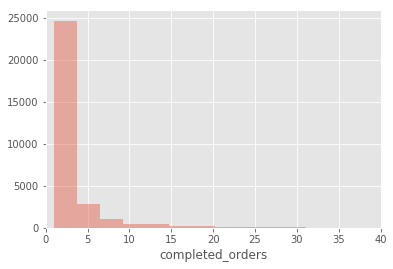

In [10]:
sns.distplot(df_comp[['customer_db_id', 'completed_orders']]
             .drop_duplicates().completed_orders, kde=False)
plt.xlim(0, 40)

(0, 300)

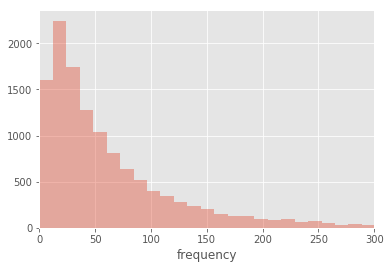

In [11]:
sns.distplot(df_comp.loc[df_comp.completed_orders > 1, ['customer_db_id', 'frequency']].drop_duplicates().frequency, kde=False)
plt.xlim(0,300)

In [12]:
df_comp.loc[df_comp.completed_orders > 1, ['customer_db_id', 'frequency']].drop_duplicates().frequency.describe()

count    12602.000000
mean        68.513697
std         76.759360
min          0.000000
25%         20.000000
50%         42.519231
75%         86.851190
max        602.000000
Name: frequency, dtype: float64

### How to define churn?
What is the distribution of time between orders?
- 75% of customers come back within 46 days for next order
- 95% of customers come back within 141 days for next order

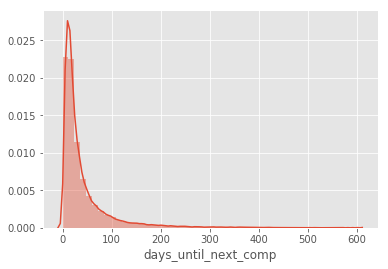

In [13]:
sns.distplot(df_comp.loc[~df_comp.days_until_next_comp.isnull(), 'days_until_next_comp'])

In [14]:
df_comp.days_until_next_comp.describe()

count    53107.000000
mean        42.241814
std         59.160311
min          0.000000
25%         12.000000
50%         22.000000
75%         47.000000
max        602.000000
Name: days_until_next_comp, dtype: float64

# Survival Analysis
How much time do customers survive on the platform?
- days between last order and first order
- only for customers with more than one order completed

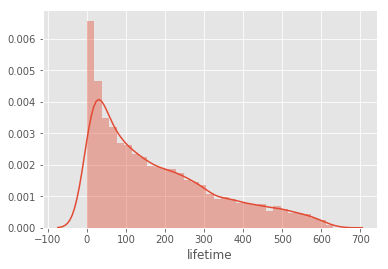

In [15]:
d = df_comp.loc[df_comp.completed_orders > 1, ['customer_db_id', 'completed_orders', 'lifetime']].drop_duplicates()
sns.distplot(d.lifetime)

Customer sample

In [16]:
df_survival = df_comp.loc[df_comp.completed_orders > 1]
df_survival = df_survival[['customer_db_id', 'lifetime', 'days_since_last_seen', 
                           'completed_orders', 'city', 'frequency']].drop_duplicates()

In [17]:
kmf = KaplanMeierFitter()

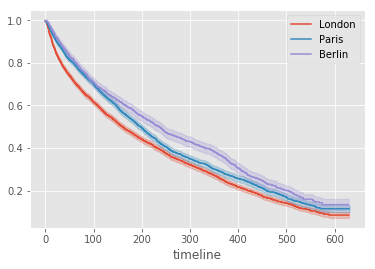

In [18]:
fig, ax = plt.subplots()
for c in df_survival.city.unique():
    df_c = df_survival.loc[df_survival.city == c]
    kmf.fit(df_c.lifetime, df_c.days_since_last_seen > 45, label=str(c))
    kmf.plot(ax=ax)

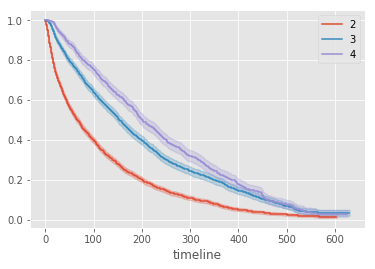

In [19]:
fig, ax = plt.subplots()
for c in range(2, 5):
    df_c = df_survival.loc[df_survival.completed_orders == c]
    kmf.fit(df_c.lifetime, df_c.days_since_last_seen > 45, label=str(c))
    kmf.plot(ax=ax)

# Braze Data

In [20]:
braze_camp = pd.read_csv('../data/braze_campaigns.csv')
braze_canv = pd.read_csv('../data/braze_canvases.csv')
braze_cust = pd.read_csv('../data/braze_customers.csv')

In [21]:
braze_camp.head()

,customer_id,api_campaign_id,converted,clicked_email,clicked_triggered_in_app_message,opened_email,opened_push,in_control,last_received,Conversion Event - B,Primary Conversion Event - A,campaign_name,variation_api_id,variation_name,campaign_num
0,CUS-A0012589,9e52c92e-f920-422c-9c2c-bf616aa469dd,NaN,NaN,NaN,NaN,NaN,False,2018-06-19T17:05:03.708Z,NaN,NaN,Push_SecretGift_DE_180619,f2d6d383-dde8-4077-8852-35f7ab9b9a39,[No name for this variation],0
1,CUS-A0012589,30fb5555-824c-440c-ad22-48be7803ae35,NaN,NaN,NaN,NaN,NaN,False,2018-06-22T16:15:04.463Z,NaN,NaN,Push_Winback_Weekend_10â‚¬_DE_Freshiers_180615,818261cd-cfc6-4768-8477-a278a7d710f9,[No name for this variation],1
2,CUS-A0012589,ebafb5a3-ce0b-4586-81ee-b3d13141d0ce,NaN,NaN,NaN,NaN,NaN,False,2018-06-25T16:15:03.943Z,NaN,NaN,PUSH_DE_FlashSale_Freshier_180625,c9586935-e727-4c50-b0c1-9f128f9d9b9a,[No name for this variation],2
3,CUS-A0012589,72f67581-b173-4c75-b8b9-ddd85b159266,NaN,NaN,NaN,NaN,NaN,False,2018-06-28T16:50:02.799Z,NaN,NaN,Push_DE_1storder_Freshiers_180625,3eff1187-bba2-46f3-9f89-45261701009e,[No name for this variation],3
4,CUS-A0012589,6ae276a3-b039-4ddb-ad69-e4ade348ec10,NaN,NaN,NaN,NaN,NaN,False,2018-08-02T12:50:06.301Z,NaN,NaN,Push_DE_HappyHour_Freshiers_180730,f9df9541-f0cc-479e-9a74-339da338284d,[No name for this variation],4


In [22]:
braze_canv.head()

,customer_id,api_canvas_id,in_control,last_entered,last_exited,last_received_message,canvas_name,steps_received,variation_name,canvas_num,api_canvas_step_id,last_received,canvas_step_name,canvas_step_num
0,CUS-A0012589,6dd36186-1881-4778-99f8-e78e572e2fc7,False,2018-09-17T16:25:03.000Z,NaN,NaN,01_DE_Freshier,[],Variant 1,0,NaN,NaN,NaN,NaN
1,CUS-A0012589,0a92983b-2290-48e6-8288-942dfa08a0b1,False,2018-09-17T16:35:02.000Z,NaN,NaN,01_DE_EN_Freshiers,[],Variant 2,1,NaN,NaN,NaN,NaN
2,CUS-A0012589,a3435f4d-34c2-4da6-975d-4ccdafc33c9e,False,2018-10-23T16:05:08.000Z,NaN,2018-09-26T16:05:25.765Z,01_DE_Freshier_Mobile,[{'name': 'Push_DE_Stage0_4_3_1_1st First Step...,Push_DE_Stage0_4_3_1_1st,2,80869eb8-8096-4143-8fc6-908c4b36b8e3,2018-08-19T16:05:06.163Z,Push_DE_Stage0_4_3_1_5th,0.0
3,CUS-A0012589,a3435f4d-34c2-4da6-975d-4ccdafc33c9e,False,2018-10-23T16:05:08.000Z,NaN,2018-09-26T16:05:25.765Z,01_DE_Freshier_Mobile,[{'name': 'Push_DE_Stage0_4_3_1_1st First Step...,Push_DE_Stage0_4_3_1_1st,2,4a261091-0025-4aad-9f96-48ce45a1c358,2018-08-21T16:05:10.465Z,Push_DE_Stage0_4_3_1_6th,1.0
4,CUS-A0012589,a3435f4d-34c2-4da6-975d-4ccdafc33c9e,False,2018-10-23T16:05:08.000Z,NaN,2018-09-26T16:05:25.765Z,01_DE_Freshier_Mobile,[{'name': 'Push_DE_Stage0_4_3_1_1st First Step...,Push_DE_Stage0_4_3_1_1st,2,7c835ea2-2ed9-4ed9-b187-6ea0b913af38,2018-08-28T16:05:13.635Z,Push_DE_Stage0_4_3_1_7th,2.0


In [23]:
braze_camp.last_received = pd.to_datetime(braze_camp.last_received)
braze_camp['last_received_day'] = (braze_camp.last_received - datetime(2017, 1, 1)).dt.days
braze_camp[['clicked_email', 'opened_email', 'opened_push', 'converted']] = braze_camp[['clicked_email', 'opened_email',
                                                                                        'opened_push', 'converted']].fillna(False)
braze_canv.last_received = pd.to_datetime(braze_canv.last_received)
braze_canv['last_received_day'] = (braze_canv.last_received - datetime(2017, 1, 1)).dt.days

Hard churn = customers who uninstalled app

In [24]:
uninstalled_cust = braze_cust.loc[~braze_cust.uninstalled_at.isnull()].customer_id
print('Uninstalled', len(uninstalled_cust), '/', len(braze_cust))

Uninstalled 3011 / 33858


In [25]:
braze_cust.email_subscribe.value_counts()

subscribed      18375
opted_in         9387
unsubscribed     6096
Name: email_subscribe, dtype: int64

In [26]:
braze_cust.push_subscribe.value_counts()

opted_in        20456
subscribed      13368
unsubscribed       34
Name: push_subscribe, dtype: int64

# Customer Lifetime

In [27]:
df_life = df_comp[['customer_id', 'order_id', 'order_comp_num', 'order_day', 'revenue', 'voucher_value', 'voucher_channel',
                   'days_since_last_comp', 'days_until_next_comp', 'final_click_channel',
                   'order_state', 'days_since_last_seen', 'completed_orders', 'num_orders']]
df_life = df_life.sort_values(['customer_id', 'order_day'])

df_life['first_order'] = df_life.order_comp_num == 0
df_life['last_order'] = df_life.order_comp_num == (df_life.completed_orders - 1)
df_life['returned'] = ~df_life.last_order

df_life['frequency'] = df_life.groupby('customer_id')['days_since_last_comp'].transform(lambda x: x.expanding().mean())
df_life['order_day_expected'] = df_life.order_day + df_life.frequency
df_life.order_day_expected = df_life.groupby('customer_id').order_day_expected.shift().fillna(df_life.order_day)
df_life['order_expected_diff'] = df_life.order_day - df_life.order_day_expected

df_life['churn_factor'] = df_life.days_until_next_comp / df_life.frequency
df_life.loc[df_life.last_order, 'churn_factor'] = df_life.days_since_last_seen / df_life.frequency

df_life['order_day_expected_45'] = df_life.order_day + 45 + 8
df_life.order_day_expected_45 = df_life.groupby('customer_id').order_day_expected_45.shift().fillna(df_life.order_day)
df_life['order_expected_45_diff'] = df_life.order_day - df_life.order_day_expected_45

df_life['churned_after'] = df_life.days_until_next_comp > (45 + 8)
df_life.loc[df_life.last_order, 'churned_after'] = df_life.days_since_last_seen > (45 + 8)
df_life['churned_before'] = df_life.groupby('customer_id').churned_after.shift().fillna(False)
df_life.loc[df_life.churned_after, 'entered_inactive'] = df_life.order_day + 45 + 8
df_life['revenue_voucher'] = df_life.revenue + df_life.voucher_value
df_life.loc[~(df_life.voucher_value > 0), 'voucher_channel'] = 'no_voucher'

df_life['returned_CRM'] = df_life.final_click_channel.str.contains('crm')
df_life['returned_CRM'] = df_life.groupby('customer_id').returned_CRM.shift(-1).fillna(False)
df_life['over_frequency'] = df_life.churn_factor >= 1

df_life = df_life.loc[df_life.completed_orders > 1]

In [28]:
df_life.voucher_channel = df_life.voucher_channel.fillna('unknown')

In [29]:
df_life.loc[df_life.customer_id == 'CUS-T3818547', 
            ['order_day', 'days_since_last_comp', 'frequency',
             'order_day_expected', 'order_expected_diff', 'order_day_expected_45', 'order_expected_45_diff']]

,order_day,days_since_last_comp,frequency,order_day_expected,order_expected_diff,order_day_expected_45,order_expected_45_diff
14550,220,NaN,NaN,220.0,0.0,220.0,0.0
14552,241,20.0,20.000000,241.0,0.0,273.0,-32.0
14553,347,106.0,63.000000,261.0,86.0,294.0,53.0
14551,414,67.0,64.333333,410.0,4.0,400.0,14.0


In [30]:
df_action_camp = braze_camp[['customer_id', 'last_received_day', 'clicked_email', 'opened_email', 
                             'opened_push', 'converted', 'campaign_name']]
df_action_camp['action'] = 'campaign'
df_action_camp['name'] = df_action_camp.campaign_name
df_action_camp['day'] = df_action_camp.last_received_day
df_action_camp['interacted'] = df_action_camp[['clicked_email', 'opened_email', 'opened_push', 'converted']].sum(axis=1) > 0
df_action_camp = df_action_camp[['customer_id', 'day', 'action', 'name', 'interacted']]

In [31]:
df_action_canv = braze_canv[['customer_id', 'last_received_day', 'canvas_step_num', 'canvas_name', 'canvas_step_name']]
df_action_canv = df_action_canv.loc[~df_action_canv.canvas_step_name.isnull()]
df_action_canv['action'] = 'canvas'
df_action_canv['day'] = df_action_canv.last_received_day
df_action_canv['name'] = df_action_canv.canvas_step_num.astype(str) + '_' + \
                         df_action_canv.canvas_name + ' / ' + \
                         df_action_canv.canvas_step_name
df_action_canv = df_action_canv[['customer_id', 'day', 'action', 'name']]

In [32]:
df_action_cust = braze_cust.set_index('customer_id').drop(['email_subscribe', 'push_subscribe'], axis=1)
df_action_cust = df_action_cust.unstack().swaplevel().reset_index()
df_action_cust.columns = ['customer_id', 'action', 'action_datetime']
df_action_cust = df_action_cust.loc[~df_action_cust.action_datetime.isnull()]
df_action_cust.action_datetime = pd.to_datetime(df_action_cust.action_datetime)
df_action_cust['day'] = (df_action_cust.action_datetime - datetime(2017, 1, 1)).dt.days
df_action_cust = df_action_cust[['customer_id', 'day', 'action']]

In [33]:
df_action = pd.concat([df_action_camp, df_action_canv, df_action_cust])
df_action.interacted = df_action.interacted.fillna(False)
df_action.name = df_action.name.fillna('')
df_action.action.unique()

array(['campaign', 'canvas', 'email_opted_in_at', 'email_unsubscribed_at',
       'push_opted_in_at', 'push_unsubscribed_at', 'uninstalled_at'],
      dtype=object)

In [34]:
# filter all data out that happened after 2018-09-30
df_action = df_action.loc[df_action.day < last_day]

In [35]:
dfa = df_action.copy()
dfl = df_life[['customer_id', 'order_day']]
dfl['action'] = 'order'
dfl.columns = ['customer_id', 'day', 'action']
dfa = dfa.append(dfl, ignore_index=True)

In [36]:
inactive_cust = df_action.loc[(df_action.action == 'canvas') & (df_action.name.str.contains('Inactive'))]['customer_id'].unique()

### Sample Customer

In [37]:
def plot_customer_lifetime(sample_customer):
    df_life_sample = df_life.loc[df_life.customer_id == sample_customer]
    df_action_sample = df_action.loc[df_action.customer_id == sample_customer]
    
    fig, ax = plt.subplots(figsize=(10,5))
    # plot vouchers
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.voucher_value > 0], 
                    x='order_day', y='voucher_value', marker='x', color='black', label='voucher_value')
    
    # plot journey and expected journy
    sns.lineplot(data=df_life_sample, x='order_day', y='revenue_voucher', 
                 marker='o', label='order revenue', color='green')
    sns.lineplot(data=df_life_sample, x='order_day_expected', y='revenue_voucher', 
                 marker='o', label='expected_order', color='gray', alpha=0.3)
    
    # plot final click channel
    sns.scatterplot(data=df_life_sample.loc[df_life_sample.final_click_channel.str.contains('crm')],
                   x='order_day', y='revenue_voucher', color='red', label='crm_click', zorder=10)
    
    # plot entering inactive segment
    sns.rugplot(df_life_sample.entered_inactive, color='black', height=1, linestyle='--', label='inactive')
    
    # plot campaigns received
    sns.rugplot(df_action_sample.loc[df_action_sample.action.isin(['campaign', 'canvas']), 'day'], 
                color='black', label='campaign')
    sns.rugplot(df_action_sample.loc[df_action_sample.interacted, 'day'], 
                color='green', label='campaign_open')
    sns.rugplot(df_action_sample.loc[(df_action_sample.name.str.contains('Inactive')), 'day'], 
            color='red', label='inactive_camp')

    
    plt.xticks(rotation=70)
    plt.ylim(0)
    plt.title(sample_customer)
    plt.legend()
    plt.show()

In [71]:
samples = df_ord.loc[(df_ord.days_until_next_order > 50) & (df_ord.completed_orders > 3) & (df_ord.order_num == 2) &
           ~(df_ord.customer_id.isin(uninstalled_cust)) & (df_ord.customer_id.isin(inactive_cust))]['customer_id'].sample(3)
samples

93801    CUS-R7055340
8876     CUS-Z0596924
34325    CUS-F4211296
Name: customer_id, dtype: object

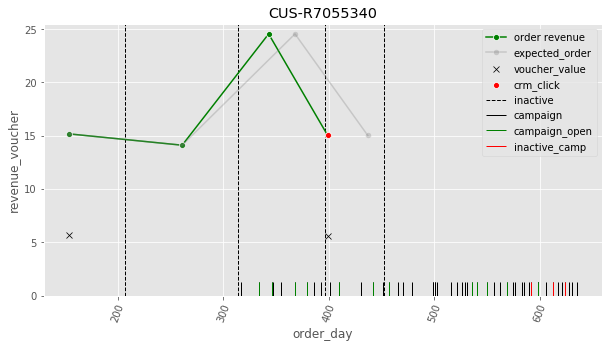

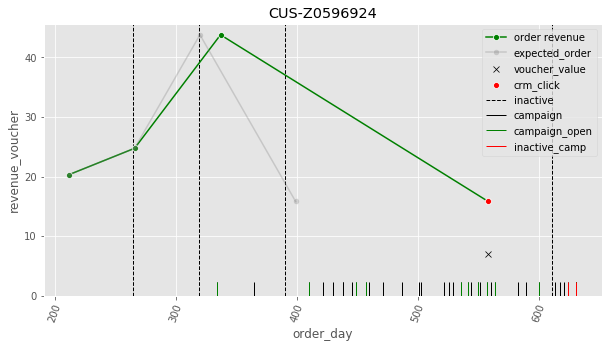

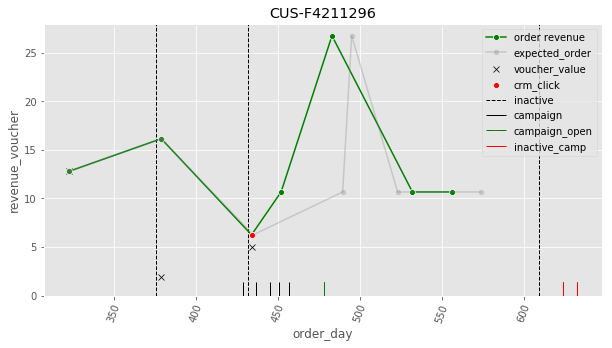

In [72]:
for s in samples:
    plot_customer_lifetime(s)

**Analyze Current Impact**
- how many campaigns usually between orders
- how much time after seen/unseeen campaign usually customer orders
- how many times customers do not open churn campaign after they churned?

In [40]:
# how many orders entered churn after
df_life.loc[df_life.churned_after].order_id.nunique()

19632

In [41]:
# how many orders entered churn and came back
df_life.loc[df_life.churned_before].order_id.nunique()

11469

In [42]:
# how many out of those were last orders
df_life.loc[df_life.last_order & df_life.churned_after].order_id.nunique()

8163

In [43]:
# how many came back through CRM
df_life.loc[df_life.final_click_channel.str.contains('crm')].order_id.nunique()

8900

In [44]:
# how many out of the churned offers got a voucher
a = df_life.loc[(df_life.churned_before) & (df_life.voucher_channel.str.contains('CRM'))]
a.order_id.nunique()

3467

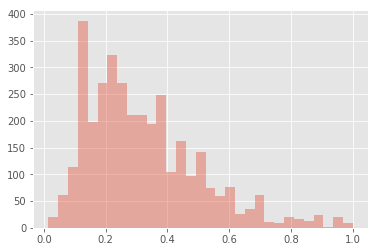

In [45]:
sns.distplot(a.voucher_value / (a.revenue + a.voucher_value), kde=False)

In [46]:
# spent on vouchers
a.voucher_value.sum()

30219.809823196534

In [47]:
a.revenue.sum()

85920.34334156383

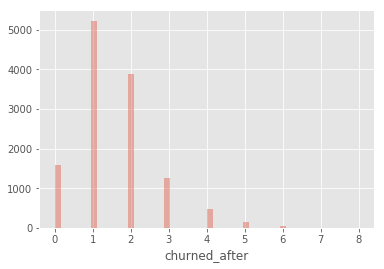

In [48]:
sns.distplot(df_life.groupby('customer_id')['churned_after'].sum(), kde=False)

(0, 20)

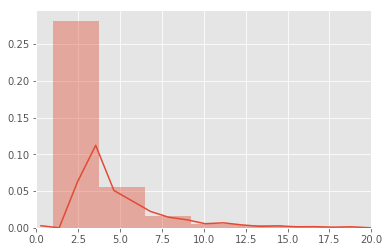

In [49]:
# how many orders after first churn
d = df_life.loc[df_life.churned_after].groupby('customer_id').first()
sns.distplot(d.completed_orders - d.order_comp_num)
plt.xlim(0,20)

# Time Prediction Comparison

In [50]:
from sklearn import metrics

(-200, 200)

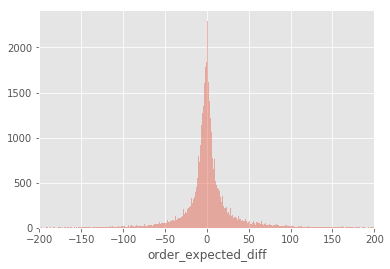

In [51]:
a = df_life.loc[df_life.order_comp_num > 1]
sns.distplot(a.order_expected_diff, bins=1000, kde=False)
plt.xlim(-200,200)

In [52]:
a.order_expected_diff.describe()

count    40514.000000
mean         2.658542
std         49.974405
min       -560.000000
25%         -8.000000
50%          0.000000
75%          9.300000
max        560.000000
Name: order_expected_diff, dtype: float64

In [53]:
metrics.mean_absolute_error(a.order_day, a.order_day_expected)

23.594522853990572

(-200, 200)

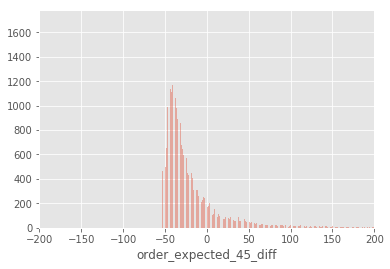

In [54]:
sns.distplot(a.order_expected_45_diff, bins=1000, kde=False)
plt.xlim(-200,200)

In [55]:
a.order_expected_45_diff.describe()

count    40514.000000
mean       -17.771437
std         45.514431
min        -53.000000
25%        -41.000000
50%        -32.000000
75%        -13.000000
max        542.000000
Name: order_expected_45_diff, dtype: float64

In [56]:
metrics.mean_absolute_error(a.order_day, a.order_day_expected_45)

37.119069951128004

In [57]:
# customers that we would expect to come back at point x, and they don't - then they get targeted - how many times does it work?
# vs. customers who were expected to come back around 45 + 8 days

In [58]:
df_life_2 = df_life.loc[df_life.order_comp_num > 1]

In [59]:
df_life_2['target_timing'] = ['soon' if x >= 53+7 else 'late' if x <= 53-7 else 'correct' for x in df_life_2.frequency]

In [60]:
stats = df_life_2.loc[df_life_2.churned_after].groupby(['target_timing', 'returned'])['order_id'].nunique().reset_index()

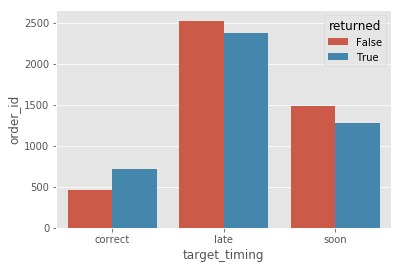

In [61]:
sns.categorical.barplot(data=stats, x='target_timing', y='order_id', hue='returned')

In [62]:
stats = df_life_2.loc[df_life_2.churned_after & df_life_2.returned]\
                .groupby(['target_timing', 'returned_CRM'])['order_id'].nunique().reset_index()

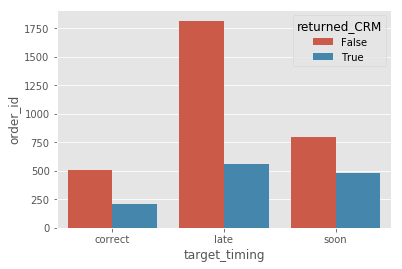

In [63]:
sns.categorical.barplot(data=stats, x='target_timing', y='order_id', hue='returned_CRM')

In [64]:
stats_by_channel = df_life_2.loc[df_life_2.churned_after & df_life_2.returned & (df_life_2.order_comp_num == 3)]\
                             .groupby(['target_timing', 'final_click_channel'])['order_id'].nunique().reset_index()

In [65]:
stats_by_channel['channel_total'] = stats_by_channel.groupby('final_click_channel')['order_id'].transform('sum')

In [66]:
stats_by_channel['order_perc'] = stats_by_channel.order_id / stats_by_channel.channel_total

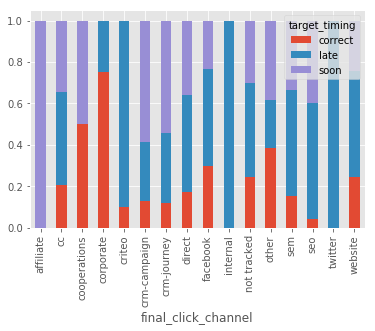

In [67]:
a = stats_by_channel.pivot(index='final_click_channel', columns='target_timing', values='order_perc').fillna(0)
a.plot(kind='bar', stacked=True)